In [32]:
from bokeh.io import output_notebook # to plot "show()" on the notebook, without opening a browser
output_notebook()

Loading BokehJS ...

In [33]:
from bloqade import var, save, load, piecewise_linear, rydberg_h
from bloqade.atom_arrangement import Chain, Square, Honeycomb, ListOfLocations
import matplotlib.pyplot as plt
import numpy as np
import os

In [34]:
s = 9.1
atom_pos = Square(3, lattice_spacing=s)
atom_pos.show()

In [35]:
def omega_with_tweaks(num_tweaks):
    duration = 9.8
    low = 0.0
    high = 10.7
    interval = duration/num_tweaks
    omega_durations_scaring = [interval for _ in range(num_tweaks)]
    omega_scaring = [low if i % 2 == 0 else high for i in range(num_tweaks+1)]
    return omega_durations_scaring, omega_scaring

In [36]:
# State Preparation
delta_durations_state_prep = [0.3, 1.6, 0.3]
delta_state_prep = [-18.8, -18.8, 16.3, 16.3] # longer than durations by 1

omega_durations_state_prep = [0.3, 1.6, 0.3]
omega_state_prep = [0.0, 15.7, 15.7, 0.0] # longer than durations by 1

# Scaring
delta_durations_scaring = [0.2, 6.6]
delta_scaring = [16.3, 0.0, 0.0] # longer than durations by 1

# omega_durations_scaring = [0.2, 1.4, 5.2]
# omega_scaring = [0, 15.7, 15.7, 0] # longer than durations by 1

omega_durations_scaring, omega_scaring = omega_with_tweaks(20)

In [37]:
run_time = var("run_time")

quantum_scar_program = (
    atom_pos
    # define detuning waveform
    .rydberg.detuning.uniform.piecewise_linear(
        delta_durations_state_prep, delta_state_prep # delta stateprep durations and values
    )
    .piecewise_linear(delta_durations_scaring, delta_scaring) # delta scaring durations and values
    # slice the detuning waveform
    .slice(start=0, stop=run_time)
    # define rabi waveform
    .amplitude.uniform.piecewise_linear(omega_durations_state_prep, omega_state_prep) # omega stateprep durations and values
    .piecewise_linear(omega_durations_scaring, omega_scaring) # omega scaring durations and values
    # slice waveform, add padding for the linear segment
    .slice(start=0, stop=run_time - 0.065)
    # record the value of the waveform at the end of the slice to "rabi_value"
    .record("rabi_value")
    # append segment to waveform that fixes the value of the waveform to 0
    # at the end of the waveform
    .linear("rabi_value", 0, 0.065)
)

# get run times via the following:
prep_times = np.array([2.2])
scar_times = np.arange(2.2, 9, 0.1)
run_times = np.unique(np.hstack((prep_times, scar_times)))

batch = quantum_scar_program.batch_assign(run_time=run_times)

print(f"State preparation ends at task {len(prep_times)}")
print(f"Tasks in total: {len(run_times)}")

State preparation ends at task 1
Tasks in total: 68


In [38]:
num_shots = 200
emu_batch = batch.bloqade.python().run(num_shots, interaction_picture=True)

In [39]:
emu_batch.report().show()

In [30]:
emu_batch.report().counts()[0]

OrderedDict([('010101010', 37),
             ('001110000', 4),
             ('001111010', 4),
             ('010010010', 4),
             ('010011010', 4),
             ('010111000', 4),
             ('000011100', 3),
             ('000111010', 3),
             ('001101010', 3),
             ('001110010', 3),
             ('010011100', 3),
             ('010101000', 3),
             ('010110001', 3),
             ('010111010', 3),
             ('011100010', 3),
             ('101010001', 3),
             ('000101010', 2),
             ('000110000', 2),
             ('000110001', 2),
             ('000110010', 2),
             ('000110011', 2),
             ('000111000', 2),
             ('001100010', 2),
             ('010001010', 2),
             ('010001011', 2),
             ('010001110', 2),
             ('010010000', 2),
             ('010010001', 2),
             ('010010100', 2),
             ('010100011', 2),
             ('010110000', 2),
             ('011110001', 2),
       

In [19]:
def Z2(L, prime=True, label_output=True):
    label = ''
    for i in range(L):
        if prime:
            label += str(i % 2)
        else:
            label += str((i + 1) % 2)
    if label_output:
        return label
    else:
        return np.array(Statevector.from_label(label))

def get_z2_probabilities(report, n_atoms, prime=False):
    z2_probabilities = []
    z2_probabilities1 = []
    
    for count in report.counts():
        z2_probability = count.get("010101010", 0) / sum(list(count.values()))
        z2_probabilities.append(z2_probability)

    return z2_probabilities

In [20]:
z2_probabilities = get_z2_probabilities(emu_batch.report(), 5)

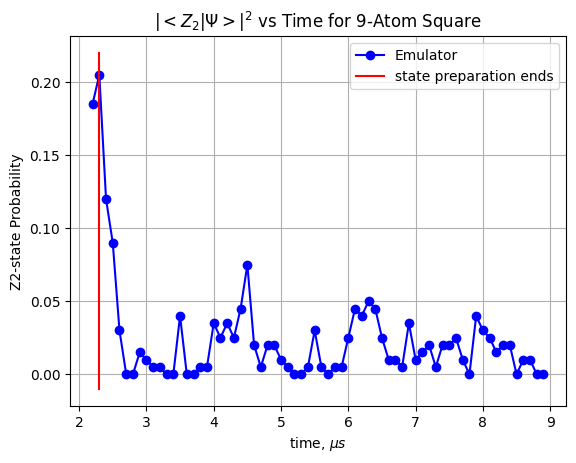

In [25]:
plt.plot(run_times, z2_probabilities, 'o-', label="Emulator", color="Blue")
plt.plot([2.3, 2.3], [-0.01, 0.22], 'r-', label='state preparation ends')
plt.xlabel('time, $\mu s$')
plt.ylabel(f"Z2-state Probability")
plt.title(f'$|<Z_2|\Psi>|^2$ vs Time for {atom_pos.n_atoms}-Atom Square')
plt.legend()
plt.grid()

In [22]:
for x, y in zip(run_times, z2_probabilities):
    print((round(x, 1), round(y, 2)), end=', ')

(2.2, 0.18), (2.3, 0.2), (2.4, 0.12), (2.5, 0.09), (2.6, 0.03), (2.7, 0.0), (2.8, 0.0), (2.9, 0.02), (3.0, 0.01), (3.1, 0.0), (3.2, 0.0), (3.3, 0.0), (3.4, 0.0), (3.5, 0.04), (3.6, 0.0), (3.7, 0.0), (3.8, 0.0), (3.9, 0.0), (4.0, 0.04), (4.1, 0.02), (4.2, 0.04), (4.3, 0.02), (4.4, 0.04), (4.5, 0.08), (4.6, 0.02), (4.7, 0.0), (4.8, 0.02), (4.9, 0.02), (5.0, 0.01), (5.1, 0.0), (5.2, 0.0), (5.3, 0.0), (5.4, 0.0), (5.5, 0.03), (5.6, 0.0), (5.7, 0.0), (5.8, 0.0), (5.9, 0.0), (6.0, 0.02), (6.1, 0.04), (6.2, 0.04), (6.3, 0.05), (6.4, 0.04), (6.5, 0.02), (6.6, 0.01), (6.7, 0.01), (6.8, 0.0), (6.9, 0.04), (7.0, 0.01), (7.1, 0.02), (7.2, 0.02), (7.3, 0.0), (7.4, 0.02), (7.5, 0.02), (7.6, 0.02), (7.7, 0.01), (7.8, 0.0), (7.9, 0.04), (8.0, 0.03), (8.1, 0.02), (8.2, 0.02), (8.3, 0.02), (8.4, 0.02), (8.5, 0.0), (8.6, 0.01), (8.7, 0.01), (8.8, 0.0), (8.9, 0.0), 